In [43]:
"本项目通过利用信用卡的历史交易数据，进行机器学习，构建信用卡反欺诈预测模型，提前发现客户**信用卡被盗刷**的事件。"

'本项目通过利用信用卡的历史交易数据，进行机器学习，构建信用卡反欺诈预测模型，提前发现客户**信用卡被盗刷**的事件。'

## 建模思路

## 项目背景

In [44]:
''' 数据集包含由欧洲持卡人于2013年9月使用信用卡进行交的数据。此数据集显示两天内发生的交易，其中284,807笔交易中有492笔被盗刷。数据集非常不平衡，
积极的类（被盗刷）占所有交易的0.172％。

它只包含作为PCA转换结果的数字输入变量。不幸的是，由于保密问题，我们无法提供有关数据的原始功能和更多背景信息。特征V1，V2，... V28是使用PCA
获得的主要组件，没有用PCA转换的唯一特征是“时间”和“量”。特征'时间'包含数据集中每个事务和第一个事务之间经过的秒数。特征“金额”是交易金额，此特
征可用于实例依赖的成本认知学习。特征'类'是响应变量，如果发生被盗刷，则取值1，否则为0。
'''


" 数据集包含由欧洲持卡人于2013年9月使用信用卡进行交的数据。此数据集显示两天内发生的交易，其中284,807笔交易中有492笔被盗刷。数据集非常不平衡，\n积极的类（被盗刷）占所有交易的0.172％。\n\n它只包含作为PCA转换结果的数字输入变量。不幸的是，由于保密问题，我们无法提供有关数据的原始功能和更多背景信息。特征V1，V2，... V28是使用PCA\n获得的主要组件，没有用PCA转换的唯一特征是“时间”和“量”。特征'时间'包含数据集中每个事务和第一个事务之间经过的秒数。特征“金额”是交易金额，此特\n征可用于实例依赖的成本认知学习。特征'类'是响应变量，如果发生被盗刷，则取值1，否则为0。\n"

## 场景解析（算法选择）

1. 首先，我们拿到的数据是持卡人两天内的信用卡交易数据，这份数据包含很多维度，要解决的问题是预测持卡人是否会发生信用卡被盗刷。信用卡持卡人是否会发生被盗刷只有两种可能，发生被盗刷或不发生被盗刷。又因为这份数据是打标好的（字段Class是目标列），也就是说它是一个监督学习的场景。于是，我们判定信用卡持卡人是否会发生被盗刷是一个**二元分类**问题，意味着可以通过二分类相关的算法来找到具体的解决办法，本项目选用的算法是逻辑斯蒂回归（Logistic Regression）。
2. 分析数据：数据是结构化数据 ，不需要做特征抽象。特征V1至V28是经过PCA处理，而特征Time和Amount的数据规格与其他特征差别较大，需要对其做特征缩放，将特征缩放至同一个规格。在数据质量方面 ，没有出现乱码或空字符的数据，可以确定字段Class为目标列，其他列为特征列。
3. 这份数据是全部打标好的数据，可以通过交叉验证的方法对训练集生成的模型进行评估。70%的数据进行训练，30%的数据进行预测和评估。
&emsp&emsp**现对该业务场景进行总结如下：**
1. 根据历史记录数据学习并对信用卡持卡人是否会发生被盗刷进行预测，二分类监督学习场景，选择逻辑斯蒂回归（Logistic Regression）算法。
1. 数据为结构化数据，不需要做特征抽象，但需要做特征缩放。

In [45]:
import pandas as pd
import numpy as np
import datetime
#画图#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import missingno as miss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  
#导入过采样的工具包处理类别不平衡问题
from imblearn.over_sampling import SMOTE
import itertools

# 1数据获取与解析

In [46]:
data_cr=pd.read_csv(r"./creditcard.csv")#读取数据
pd.set_option('display.float_format', lambda x: '%.3f' % x)#设置pandas读入数据保留3位小数点
data_cr.head()#查看数据的前5行，目的是快速查看数据的基本信息

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


从上面可以看出，数据为结构化数据，不需要抽特征转化，但特征Time和Amount的数据规格和其他特征不一样，需要对其做特征做特征缩放。

In [47]:
data_cr.shape

(284807, 31)

表明此数据有28万行，31列

In [48]:
data_cr.info()#查看数据基本类型msno.matrix(data_cr) # 查看缺失值情况

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

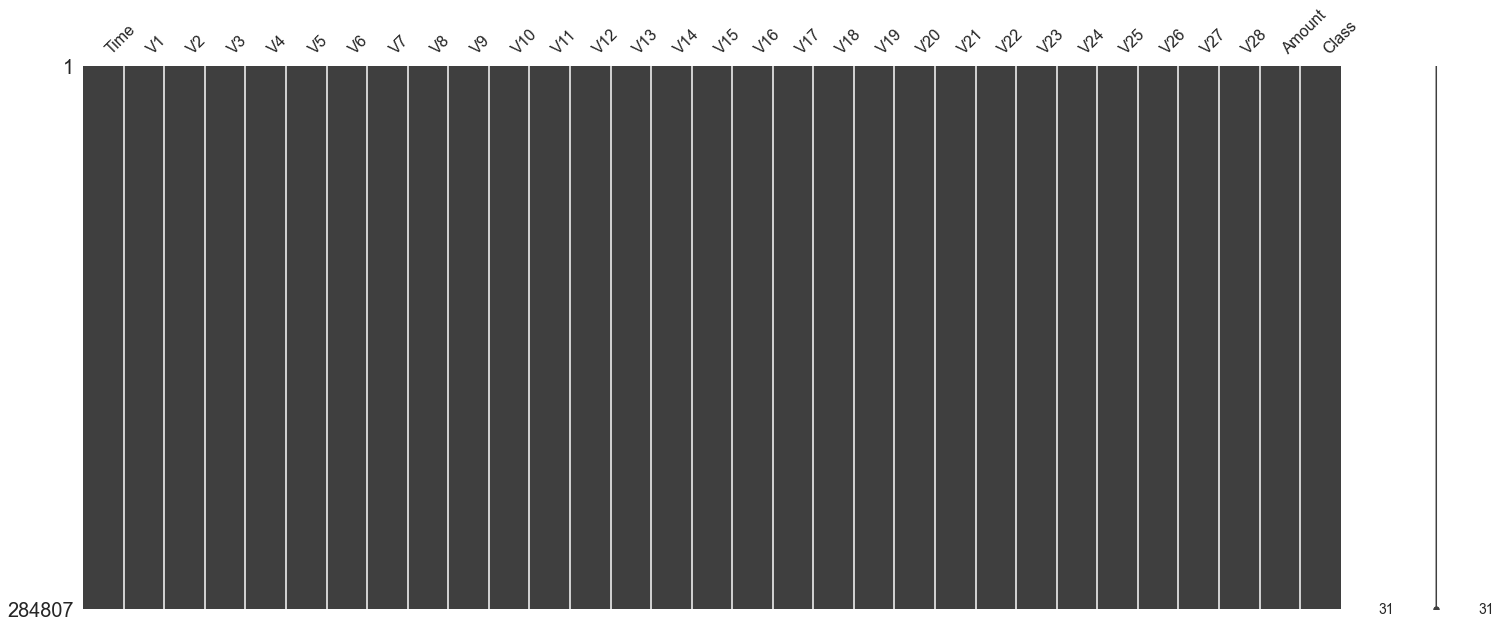

In [49]:
miss.matrix(data_cr) # 查看缺失值情况

说明数据类型只有float64和int64，且无缺失值，方便后续处理

# 2特征工程

Text(0.5, 1.0, '目标变量中的每类频率分布饼图')

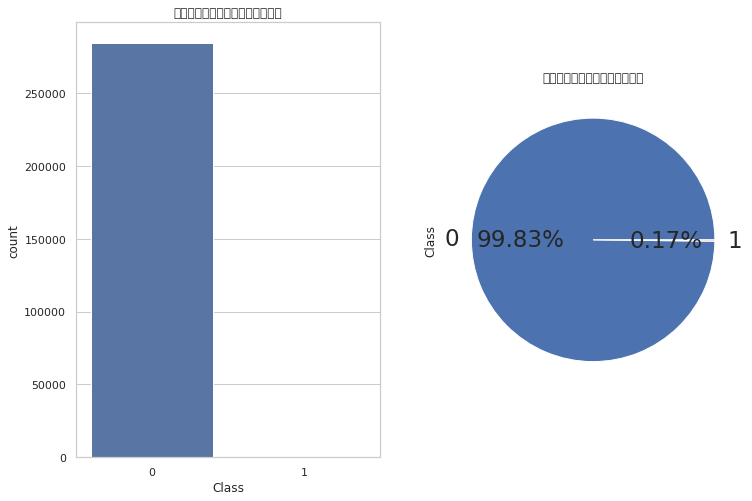

In [50]:
#目标变量可视化
fig,ax=plt.subplots(1,2,figsize=(12,8))
sns.set(style="darkgrid")
sns.countplot(x="Class",data=data_cr,ax=ax[0])
from pylab import mpl#用于显示中文
mpl.rcParams['font.sans-serif'] = ['SimHei']   # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False          # 解决保存图像是负号'-'显示为方块的问题
ax[0].set_title("目标变量中每类的频数分布直方图")
data_cr["Class"].value_counts().plot(kind="pie",ax=ax[1],fontsize=23,autopct='%1.2f%%')#长度为1，保留百分号前面的2个小数点
ax[1].set_title("目标变量中的每类频率分布饼图")

In [51]:
data_cr["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

通过上面的图和数据可知，存在492例盗刷，占总样本的0.17%，由此可知，这是一个明显的数据类别不平衡问题，稍后我们采用过采样(增加数据)的方法对这种问题进行处理。

## 特征转换,将时间从单位每秒化为单位每小时

In [52]:
data_cr["Time"]=data_cr["Time"].apply(lambda x: divmod(x,3600)[0])

## 特征选择

In [53]:
# v_feature=data_cr.iloc[:,1:29].columns#获取特征名
# plt.figure(figsize=(16,28*4))
# gs=gridspec.GridSpec(28,1)
# for i,cn in enumerate(v_feature):
#     ax=plt.subplot(gs[i])
#     sns.distplot(data_cr[cn][data_cr["Class"]==1],bins=50)
#     sns.distplot(data_cr[cn][data_cr["Class"]==0],bins=100)   
#     ax.set_label("")
#     ax.set_title("直方图分布"+str(cn))
#plt.savefig("f:/desktop/直方图分布.jpg")

上图是不同变量在信用卡被盗刷和信用卡正常的不同分布情况，我们将选择在不同信用卡状态下的分布有明显区别的变量。因此剔除变量V8、V13 、V15 、V20
、V21 、V22、 V23 、V24 、V25 、V26 、V27 和V28变量。

In [54]:
#删除相关变量
droplist=["V8","V13","V15","V20","V21","V22","V23","V24","V25","V26","V27","V28"]#提成相关性较弱的12列，还剩下19列
data_new=data_cr.drop(droplist,axis=1)
data_new.shape

(284807, 19)

In [55]:
data_new.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Amount', 'Class'],
      dtype='object')

## 特征缩放

In [56]:
data_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.364,0.091,-0.552,-0.618,-0.311,-0.470,0.208,0.026,0.404,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,-0.255,-0.167,1.613,1.065,-0.144,0.464,-0.115,-0.183,-0.146,2.690,0
2,0.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,-1.515,0.208,0.625,0.066,-0.166,-2.890,1.110,-0.121,-2.262,378.660,0
3,0.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,-1.387,-0.055,-0.226,0.178,-0.288,-1.060,-0.684,1.966,-1.233,123.500,0
4,0.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,0.818,0.753,-0.823,0.538,-1.120,-0.451,-0.237,-0.038,0.803,69.990,0


Amount变量和Time变量的取值范围与其他变量相差较大，所以要对其进行特征缩放

In [57]:
col=["Amount","Time"]
from sklearn.preprocessing import StandardScaler
data_new[col]=StandardScaler().fit_transform(data_new[col])
data_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class
0,-1.960,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.364,0.091,-0.552,-0.618,-0.311,-0.470,0.208,0.026,0.404,0.245,0
1,-1.960,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,-0.255,-0.167,1.613,1.065,-0.144,0.464,-0.115,-0.183,-0.146,-0.342,0
2,-1.960,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,-1.515,0.208,0.625,0.066,-0.166,-2.890,1.110,-0.121,-2.262,1.161,0
3,-1.960,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,-1.387,-0.055,-0.226,0.178,-0.288,-1.060,-0.684,1.966,-1.233,0.141,0
4,-1.960,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,0.818,0.753,-0.823,0.538,-1.120,-0.451,-0.237,-0.038,0.803,-0.073,0


## 对特征的重要性进行排序，以进一步减少变量

(-1.0, 18.0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


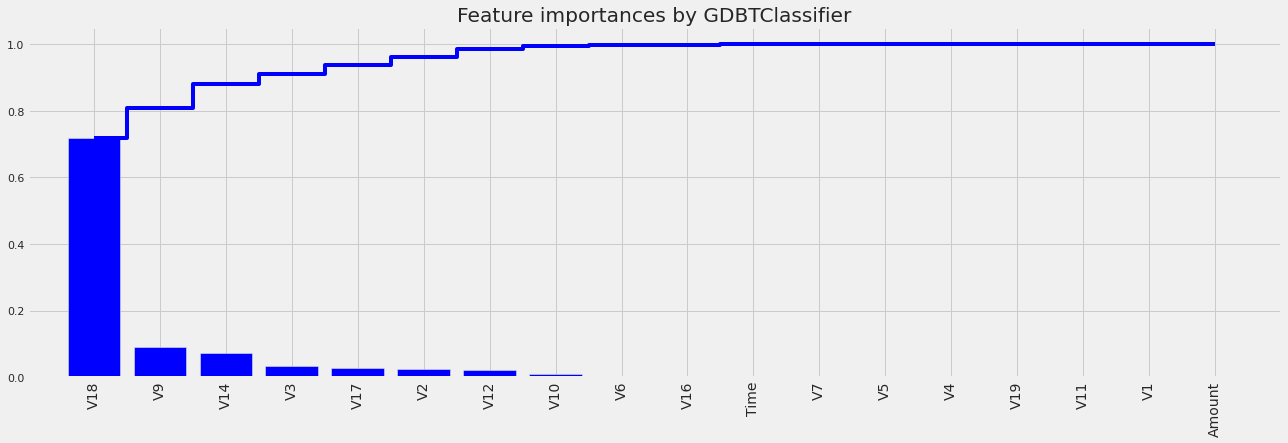

In [58]:
#构造X和Y变量
x_val=data_new.iloc[:,:-1]
y_val=data_new.iloc[:,-1]
#利用GBDT梯度提升决策树进行特征重要性排序(也可以用随机森林)
from sklearn.ensemble import GradientBoostingClassifier as GDBT
clf=GDBT()
clf.fit(x_val,y_val)
#排序可视化
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)
importance=clf.feature_importances_
feature_name=data_new.columns[:-1]
indices=np.argsort(importance)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by GDBTClassifier")
plt.bar(range(len(importance)),importance[indices],color="blue",align="center")
plt.step(range(len(importance)),np.cumsum(importance[indices]),color="blue",where="mid",label="cumulative")
plt.xticks(range(len(importance)),feature_name[indices],rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

In [59]:
droplist1=["Amount","V5","V1","V2","V9","V4","V19","V18","Time"]
data_new1=data_new.drop(droplist1,axis=1)

# 模型训练
**处理样本不平衡问题**

目标变量“Class”正常和被盗刷两种类别的数量差别较大，会对模型学习造成困扰。举例来说，假如有100个样本，其中只有1个是被盗刷样本，其余99个全为正常样本，那么学习器只要制定一个简单的方法：即判别所有样本均为正常样本，就能轻松达到99%的准确率。而这个分类器的决策对我们的风险控制毫无意义。因此，在将数据代入模型训练之前，我们必须先解决样本不平衡的问题。
**现对该业务场景进行总结如下：**
1. 过采样（oversampling），增加正样本使得正、负样本数目接近，然后再进行学习。
2. 欠采样（undersampling），去除一些负样本使得正、负样本数目接近，然后再进行学习。
本次处理样本不平衡采用的方法是**过采样**，具体操作使用SMOTE（Synthetic Minority Oversampling Technique），SMOET的基本原理是：采样最邻近算法，计算出每个少数类样本的K个近邻，从K个近邻中随机挑选N个样本进行随机线性插值，构造新的少数样本，同时将新样本与原数据合成，产生新的训练集。更详细说明参考CMU关于SMOTE: [Synthetic Minority Over-sampling Technique](http://link.zhihu.com/?target=http%3A//www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html)的介绍。

# SMOTE过采样

In [60]:
#重新构造X变量和Y变量
x_all=data_new1.iloc[:,:-1]
y_all=data_new1.iloc[:,-1]

X_train,X_test,Y_train,Y_test=train_test_split(x_val,y_val,test_size=0.3)
n_samples=len(Y_train)
pos_samples=Y_train[Y_train==1].shape[0]
print("过采样之前被盗刷所占的比例{:.2%}".format(pos_samples/n_samples))
#为了保证预测的数据分布的真实性，所以我们只在训练集上进行过采样处理
X_train_new,Y_train_new=SMOTE(random_state=12).fit_resample(X_train,Y_train)
n_samples_new=len(Y_train_new)
pos_samples_new=Y_train_new[Y_train_new==1].shape[0]
print("过采样之后被盗刷所占的比例{:.2%}".format(pos_samples_new/n_samples_new))

过采样之前被盗刷所占的比例0.18%
过采样之后被盗刷所占的比例50.00%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


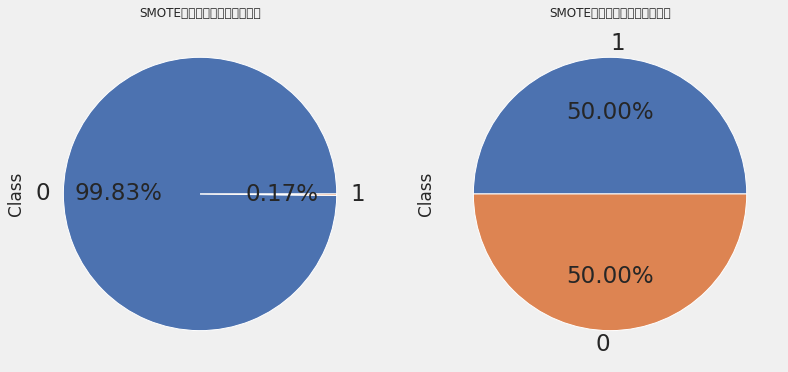

In [61]:
fig,ax=plt.subplots(1,2,figsize=(12,8))
sns.set(style="darkgrid")
from pylab import mpl#用于显示中文
mpl.rcParams['font.sans-serif'] = ['SimHei']   # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False          # 解决保存图像是负号'-'显示为方块的问题
data_cr["Class"].value_counts().plot(kind="pie",ax=ax[0],fontsize=23,autopct='%1.2f%%')
ax[0].set_title("SMOTE采样之前的频率分布饼图")
pd.Series(Y_train_new).value_counts().plot(kind="pie",ax=ax[1],fontsize=23,autopct='%1.2f%%')#长度为1，保留百分号前面的2个小数点
ax[1].set_title("SMOTE采样之后的频率分布饼图")
ax[1].set_ylabel("Class")
plt.savefig("smote.jpg")

# 自定义可视化函数

In [62]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")#若对应格子上面的数量不超过阈值则，上面的字体为白色，为了方便查看

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 单独的逻辑回归求得查全率Recall rate

逻辑回归在测试集上的查全率（Recall rate）:  0.9097744360902256


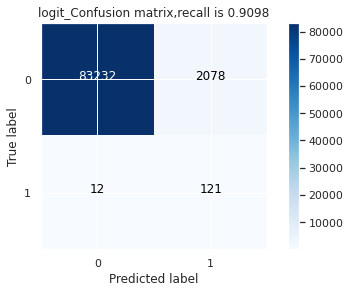

In [63]:
from sklearn.linear_model import LogisticRegression
lg_clf=LogisticRegression()
lg_clf.fit(X_train_new,Y_train_new)
lg_pred=lg_clf.predict(X_test)
cnf_matrix_lg = confusion_matrix(Y_test,lg_pred)  # 生成混淆矩阵
np.set_printoptions(precision=2)#精确到两位小数点
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,4))
plt.subplot(111)
plot_confusion_matrix(cnf_matrix_lg
                      , classes=class_names
                      , title='logit_Confusion matrix,recall is {:.4f}'.format(cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1])))
print("逻辑回归在测试集上的查全率（Recall rate）: ", cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1]))
plt.savefig(r"logic.jpg",dpi=600)
plt.show()

# 利用GridSearchCV进行交叉验证和模型参数自动调优

In [64]:
#利用逻辑回归算法分类
from sklearn.linear_model import LogisticRegression
para_logit= {'C': [100,1,10]}#候选参数集
clf=GridSearchCV(LogisticRegression(dual=False),param_grid=para_logit,cv=10,iid=False,n_jobs=-1)#构建分类器，10折交叉验证
clf.fit(X_train_new,Y_train_new)#使用训练集进行训练
print("最佳参数组合: {}".format(clf.best_params_))
print("最佳交叉验证拟合分数{:.5f}".format(clf.best_score_))
print(type(clf), '#'*10, '1')

import joblib

#save your model or results
joblib.dump(clf, 'model_file_name.pkl')

#load your model for further usage
# joblib.load("model_file_name.pkl")
# joblib.dump(clf.best_estimator_, 'clf_model.pkl')

最佳参数组合: {'C': 1}
最佳交叉验证拟合分数0.93721
<class 'sklearn.model_selection._search.GridSearchCV'> ########## 1


['model_file_name.pkl']

# 预测

In [65]:
y_pred = clf.predict(X_test)
print("预测集的准确率: {:.5f}".format(accuracy_score(Y_test, y_pred,)))

预测集的准确率: 0.97554


# 结果可视化

逻辑回归在测试集上的查全率（Recall rate）:  0.9097744360902256
GridSearchCV在测试集上的查全率（Recall rate）:  0.9097744360902256


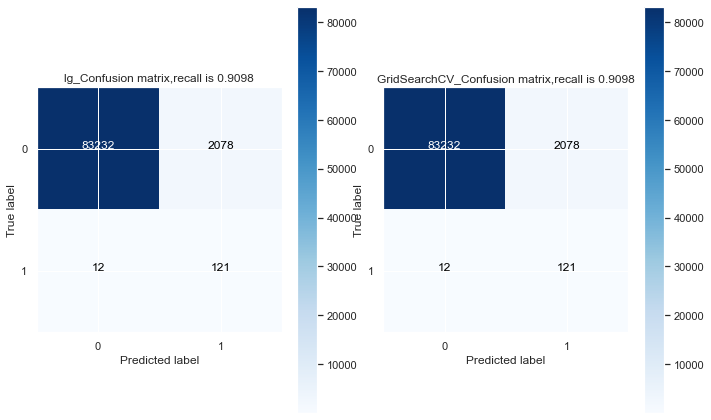

In [71]:
# Compute confusion matrix
cnf_matrix_lg = confusion_matrix(Y_test,lg_pred)  # 生成混淆矩阵
cnf_matrix_gd = confusion_matrix(Y_test,y_pred)  # 生成混淆矩阵
np.set_printoptions(precision=2)#精确到两位小数点
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(10,6))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix_lg
                      , classes=class_names
                      , title='lg_Confusion matrix,recall is {:.4f}'.format(cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1])))
plt.subplot(122)
plot_confusion_matrix(cnf_matrix_gd
                      , classes=class_names
                      , title='GridSearchCV_Confusion matrix,recall is {:.4f}'.format(cnf_matrix_gd[1,1]/(cnf_matrix_gd[1,0]+cnf_matrix_gd[1,1])))
print("逻辑回归在测试集上的查全率（Recall rate）: ", cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1]))
print("GridSearchCV在测试集上的查全率（Recall rate）: ", cnf_matrix_gd[1,1]/(cnf_matrix_gd[1,0]+cnf_matrix_gd[1,1]))
plt.show()

In [74]:
# li=[]
# for i in Y_test[Y_test==1].index:
#     li.append(i)
# X_test_pos=X_test.loc[li,:]
# Y_test_pos=Y_test[Y_test==1]
# y_pred_pos = clf_lgb.predict(X_test_pos)
# print("预测集中被盗刷的准确率: {:.5f}".format(accuracy_score(Y_test_pos, y_pred_pos,)))

# 模型评估

解决不同的问题，通常需要不同的指标来度量模型的性能。例如我们希望用算法来预测癌症是否是恶性的，假设100个病人中有5个病人的癌症是恶性，
对于医生来说，尽可能提高模型的**查全率（recall）比提高查准率（precision）**更为重要，因为站在病人的角度，**发生漏发现癌症为恶性比发生误
判为癌症是恶性更为严重。**

由此可见就上面的两个算法而言，明显lgb过拟合了，考虑到样本不均衡问题，故应该选用简单一点的算法（逻辑回归）来减少陷入过拟合的陷阱。

## 考虑设置阈值，来调整预测被盗刷的概率，依次来调整模型的查全率（Recall）

When threshold is 0.1,  Recall rate is 0.97744,  AUC is 0.86101
When threshold is 0.2,  Recall rate is 0.95489,  AUC is 0.92337
When threshold is 0.3,  Recall rate is 0.93985,  AUC is 0.93924
When threshold is 0.4,  Recall rate is 0.92481,  AUC is 0.94311
When threshold is 0.5,  Recall rate is 0.90977,  AUC is 0.94271
When threshold is 0.6,  Recall rate is 0.90226,  AUC is 0.94284
When threshold is 0.7,  Recall rate is 0.90226,  AUC is 0.94511
When threshold is 0.8,  Recall rate is 0.89474,  AUC is 0.94267
When threshold is 0.9,  Recall rate is 0.87218,  AUC is 0.93298


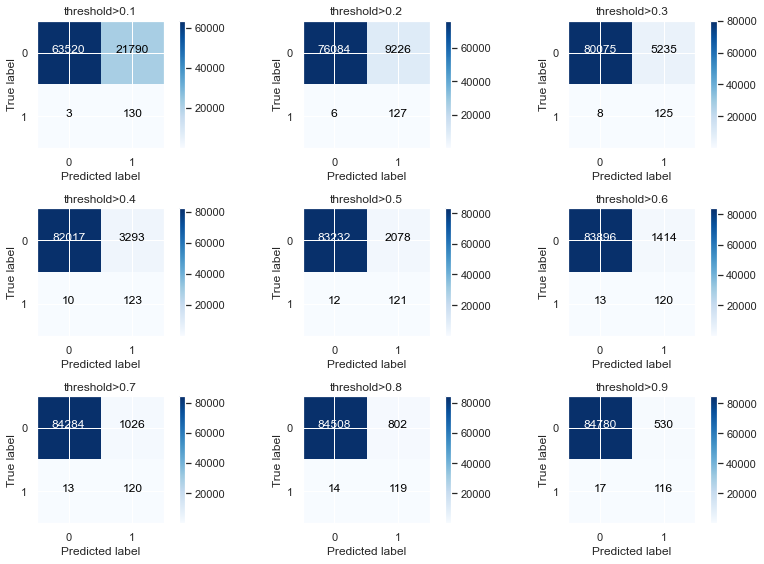

In [75]:
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])
y_pred_proba=clf.predict_proba(X_test)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]#设定不同的阈值，本来原始的阈值是0.5
plt.figure(figsize=(12,8))
j=1
re=[]
pr=[]
a=[]
for i,color in zip(thresholds,colors):
    y_test_predictions_high_recall=y_pred_proba[:,1]>i#将预测为被盗刷的概率值与阈值作比较，大于阈值则预测为被盗刷，小于阈值则预测为正常
    plt.subplot(3,3,j)
    j+=1
    # Compute confusion matrix
    cnf_matrix1 = confusion_matrix(Y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    fpr, tpr, _ = roc_curve(Y_test, y_test_predictions_high_recall)
    area = auc(fpr, tpr)
    recall_rate=cnf_matrix1[1,1]/(cnf_matrix1[1,0]+cnf_matrix1[1,1])#查全率
    precision_rate=(cnf_matrix1[1,1]+cnf_matrix1[0,0])/(cnf_matrix1.sum())#准确率
    print("When threshold is {0},  Recall rate is {1:0.5f},  AUC is {2:.5f}".format(i, recall_rate,area))
    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix1, classes=class_names,title="threshold>{}".format(i)) 
    re.append(recall_rate)
    pr.append(precision_rate)
    a.append(area)

# 趋势图

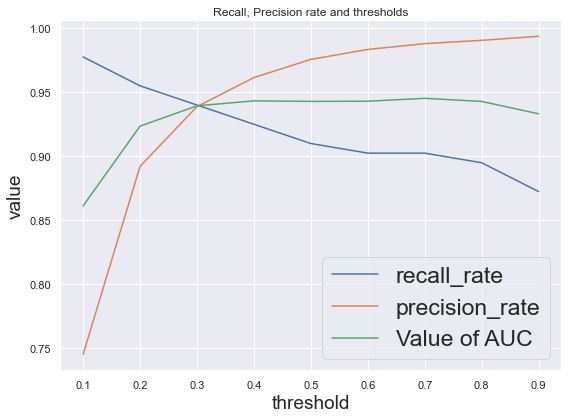

In [76]:
plt.figure(figsize=(8,6))
sns.set()
plt.plot(thresholds,re,label="recall_rate")
plt.plot(thresholds,pr,label="precision_rate")
plt.plot(thresholds,a,label="Value of AUC")
plt.legend(fontsize=23)
plt.xlabel("threshold",fontsize=19)
plt.ylabel("value",fontsize=19)
plt.title("Recall, Precision rate and thresholds")
plt.show()

由上图所见，随着阈值逐渐变大，Recall rate逐渐变小，Precision rate逐渐变大，AUC值先增后减，阈值等于5时，AUC值最大